0) puede que lo predizca tan bien porque las muestras están repetidas, asi que usaremos los nuevos datos para hacer el test real (hacer el una fucion que te haga todo, 
    1) le pasas las varaibles
    2) te calcula las mtricas 
    3) con el modelo cargado te hace las prediccion y leugo ver los resultados.
1) descargasr los datos del S&P e IBEX, ver si estan en el modelo y clasificar esas compaññias a dia de hoy
2) reducir el numbero de arboles del random forest
3) hacer con el algoritmo de random forest
4) hacer todo esto en el mismo sitio y que te saque los plot juntos para todos los modelos y poder comentar los mdelos que hemos usado y los resutlaos en un solo sitio
5) limpiar el codigo,
6) escribir el articulo
    - Hacer un trabajo modo paper sobre uno de los temas, entrega limite el 15 de abril
    - Hacer un buen análisis bibliográfico
    - Descripción del método de la estadística
    - Mientras más cercano sea a la realidad más puntación tendrá
    - La preguntas del examen estarán contenidas en el tema de lecciones
        - En recurso el temario es mucho más extenso
    - Cuanto más corto sea mejor
    - Hacer el análisis de inferencia estadística
    - Ver que ten todos los temas de las notas
    - Hacer una regresion logistica multinomial ordenada? Decir las varailas (numericas,  categoricas con y sin orden , para la x la y etc) que tengo y como son y ver el tipo de regreison 
    - HAcer con  más datos, los que no tiene  rating y ver su distrución 
    

7) Ver los Do To Futuros
    - Sacar el cost of debt (para en caso de que lo tengamos hacer otro modelo)
    - Aplicar más tecnicas de ML (esto no es predición esto es estimacion de una compañía actual)
    - Scar el tamañao de la empresa - market cap
    - Pensar si normalizar los datos para el entrenamiento
    - Sacar esto con las nuevas varaibles (con market cap porque las comps siempre seran cotizadas) 
    - y si solo lo hacemos para un año concreto , cuantas salen?
    - Poder usar este modelo desde excel (sacar los datos y la caslficaicon de las industrias y los rating)

7) mandar correo al profresor

## Usos de los modelos
0) puede que lo predizca tan bien porque las muestras están repetidas, asi que usaremos los nuevos datos para hacer el test real (hacer el una fucion que te haga todo, 
    1) le pasas las varaibles
    2) te calcula las mtricas 
    3) con el modelo cargado te hace las prediccion y leugo ver los resultados.

In [25]:
# read the data/2024_main_comps.xlsx
import pandas as pd
from standard_data import *
import numpy as np
import json
from sklearn.metrics import mean_absolute_error,mean_squared_error
from joblib import load

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

In [26]:
def preprocesado_df(file):
    """
    Function to read the data
    Delete NanN
    Compute the main matric
    Transform the categorical data
    """
    df_base = pd.read_excel(file, skiprows=3, usecols="B:O")
    df = df_base
    mask = (df[columns_to_check] != 0) & (df[columns_to_check] != "NaN")
    df = df[mask.any(axis=1)]
    
    df = df.copy()
    for columnas in columns_to_check:
        df[columnas] = pd.to_numeric(df[columnas], errors='coerce')
    df = compute_main_ratios(df)

    # Delete rows and columns that are not necesarry
    dif_of_0 = ["Total Equity","Current Liabilities","Total Debt","EBITDA"]
    for col_ in dif_of_0:
        df = df[df[col_] != 0]
    df.dropna(inplace=True)
    df = df[var_x_num+['Rating','Sector']]
    
    # Pasamos las varaibles categoricas a ordinales
    df.loc[:,'Rating_group'] = df['Rating'].map(All_rating_order_group)
    
    df.loc[:,'Sector_ordinal'] = df['Sector'].map(sectores_dic)

    with open('dicts_ratings.json', 'r') as file:
            dict_ratings = json.load(file)
    
    df.loc[:,'Rating_ordinal'] = df['Rating'].map(dict_ratings)

    with open('dicts_ratings_group.json', 'r') as file:
            dict_ratings = json.load(file)
    
    df.loc[:,'Rating_group_ordinal'] = df['Rating_group'].map(dict_ratings)
    
    # Solo las variables que necesitamos para el modelo
    df = df[['Rating_ordinal','Rating_group_ordinal'] + var_x_num + ['Sector_ordinal']]
    return df_base, df

file = 'data/2024_main_comps.xlsx'
(df_base, df) = preprocesado_df(file)

In [27]:
# count the number of nan in each column
df.isna().sum()

Rating_ordinal              897
Rating_group_ordinal        897
Net Debt to EBITDA            0
Debt to Assets                0
Current Ratio                 0
Quick Ratio                   0
Cash ratio                    0
Long Term Debt to Equity      0
Debt to Equity                0
Debt ratio                    0
Financial Leverage            0
Sector_ordinal                0
dtype: int64

In [28]:
# filter de df only if the value in the column 'Rating_ordina' is a number
df = df[df['Rating_ordinal'].notna()]
df.isna().sum()

Rating_ordinal              0
Rating_group_ordinal        0
Net Debt to EBITDA          0
Debt to Assets              0
Current Ratio               0
Quick Ratio                 0
Cash ratio                  0
Long Term Debt to Equity    0
Debt to Equity              0
Debt ratio                  0
Financial Leverage          0
Sector_ordinal              0
dtype: int64

In [29]:
#check if the are inf in the df
df.isin([np.inf, -np.inf]).sum()

Rating_ordinal              0
Rating_group_ordinal        0
Net Debt to EBITDA          0
Debt to Assets              0
Current Ratio               0
Quick Ratio                 0
Cash ratio                  0
Long Term Debt to Equity    0
Debt to Equity              0
Debt ratio                  0
Financial Leverage          0
Sector_ordinal              0
dtype: int64

### Modelo logistico

In [31]:
var_x = var_x_num + ['Sector_ordinal']
X = df[var_x] 
y = np.array(df['Rating_group_ordinal']) 
print(df.shape)

(753, 12)


In [40]:
# Realizar predicciones sobre el conjunto de prueba
model = load('models/logistic_model.sav')
y_pred = model.predict(X)

In [41]:
mse = mean_squared_error(y, y_pred)
print(f"Error Cuadrático Medio (MSE): {mse}")

mae = mean_absolute_error(y, y_pred)
print(f"Error Absoluto Medio (MEA): {mae}")

Error Cuadrático Medio (MSE): 6.411686586985391
Error Absoluto Medio (MEA): 2.361221779548473


In [42]:
ratings_ = rating_order_group.copy()
ratings_.remove('D')
print('Rating in the list',set(ratings_))

with open('dicts_ratings_group.json', 'r') as file:
    dict_ratings = json.load(file)
# invert the keys and values of the dit
dict_ratings = {v: k for k, v in dict_ratings.items()}
our_ratings = {dict_ratings[x] for x in set(df['Rating_group_ordinal'])}
print('Rating in our data',our_ratings)

print('Ratings not in our list',set(ratings_)-set(our_ratings))

Rating in the list {'CCC', 'BBB', 'A', 'BB', 'AAA', 'CC', 'AA', 'B'}
Rating in our data {'CCC', 'BBB', 'A', 'BB', 'AAA', 'AA', 'B'}
Ratings not in our list {'CC'}


In [43]:
set(y_pred)

{0, 1, 2, 3, 4, 5, 6, 7}

In [44]:
#count the number of times the prediction value is equal to the real value over the total number of predictions
print('Number of times it predict the exact number :',np.round(np.sum(y_pred == y) / len(y),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 1 different:',np.round(np.sum(abs(y_pred - y) <= 1) / len(y),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 2 different:',np.round(np.sum(abs(y_pred - y) <= 2) / len(y),4)*100,'%')

Number of times it predict the exact number : 3.05 %
Number of times it predict the exact number or 1 different: 15.27 %
Number of times it predict the exact number or 2 different: 53.39 %


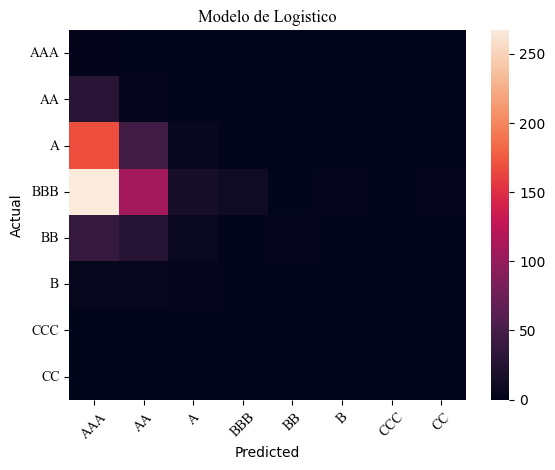

In [45]:
# plot the  Confusion Matrix for the companies in the main world index
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm,  fmt="d")
# usa All_rating_order_group como ticks en el eje x e y
ticks = np.arange(len(ratings_))+0.5
plt.xticks(ticks=ticks, labels=ratings_,rotation=45,fontname='Times New Roman')
plt.yticks(ticks=ticks, labels=ratings_,rotation=0,fontname='Times New Roman')
plt.title('Modelo de Logistico',fontname='Times New Roman')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('plots/confusion_matrix_logistic_new_data.png')
plt.show()

### Modelo regresión

In [46]:
# Realizar predicciones sobre el conjunto de prueba
model = load('models/polyreg_model.sav')
y_pred = model.predict(X)

In [47]:
mse = mean_squared_error(y, y_pred)
print(f"Error Cuadrático Medio (MSE): {mse}")

mae = mean_absolute_error(y, y_pred)
print(f"Error Absoluto Medio (MEA): {mae}")

Error Cuadrático Medio (MSE): 5973724117555747.0
Error Absoluto Medio (MEA): 3197613.8834739593


In [48]:
ratings_ = All_rating_order.copy()
ratings_.remove('D')
ratings_.remove('SD')
print('Rating in the list',set(ratings_))

with open('dicts_ratings.json', 'r') as file:
    dict_ratings = json.load(file)
# invert the keys and values of the dit
dict_ratings = {v: k for k, v in dict_ratings.items()}
our_ratings = {dict_ratings[x] for x in set(df['Rating_ordinal'])}
print('Rating in our data',our_ratings)

print('Ratings not in our list',set(ratings_)-set(our_ratings))

Rating in the list {'CC', 'AA', 'CCC+', 'AA+', 'BB', 'BB+', 'AAA', 'BBB+', 'BB-', 'AA-', 'B', 'CCC-', 'CCC', 'A-', 'A+', 'B+', 'BBB', 'A', 'BBB-', 'B-'}
Rating in our data {'CCC', 'BBB', 'A', 'BB', 'BBB-', 'A-', 'BB+', 'AAA', 'BBB+', 'AA', 'BB-', 'A+', 'B+', 'B-', 'AA-', 'AA+', 'B'}
Ratings not in our list {'CCC+', 'CC', 'CCC-'}


In [49]:
#count the number of times the prediction value is equal to the real value over the total number of predictions
print('Number of times it predict the exact number :',np.round(np.sum(y_pred == y) / len(y),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 1 different:',np.round(np.sum(abs(y_pred - y) <= 1) / len(y),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 2 different:',np.round(np.sum(abs(y_pred - y) <= 2) / len(y),4)*100,'%')

Number of times it predict the exact number : 0.0 %
Number of times it predict the exact number or 1 different: 44.75 %
Number of times it predict the exact number or 2 different: 66.93 %


In [50]:
y_pred_rounded = np.round(y_pred, decimals=0)
y_pred_rounded= np.clip(y_pred_rounded, 0, 19)
print(set(y_pred_rounded))

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 14.0, 15.0, 18.0, 19.0}


In [51]:
len(y),len(y_pred)

(753, 753)

In [52]:
# plot the  Confusion Matrix for the companies in the main world index
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm,  fmt="d")
# usa All_rating_order_group como ticks en el eje x e y
ticks = np.arange(len(ratings_))+0.5
plt.xticks(ticks=ticks, labels=ratings_,rotation=45,fontname='Times New Roman')
plt.yticks(ticks=ticks, labels=ratings_,rotation=0,fontname='Times New Roman')
plt.title('Modelo de Regresión Polinómicat',fontname='Times New Roman')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('plots/confusion_matrix_polreg_new_data.png')
plt.show()

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

### Modelo de ML

In [53]:
X = df[var_x] 
y = np.array(df['Rating_ordinal']) 

In [54]:
# Realizar predicciones sobre el conjunto de prueba
model = load('models/rf_model.pkl')
y_pred = model.predict(X)

In [55]:
mse = mean_squared_error(y, y_pred)
print(f"Error Cuadrático Medio (MSE): {mse}")

mae = mean_absolute_error(y, y_pred)
print(f"Error Absoluto Medio (MEA): {mae}")

Error Cuadrático Medio (MSE): 7.841965471447543
Error Absoluto Medio (MEA): 1.4302788844621515


In [56]:
ratings_ = All_rating_order.copy()
ratings_.remove('D')
ratings_.remove('SD')
print('Rating in the list',set(ratings_))

with open('dicts_ratings.json', 'r') as file:
    dict_ratings = json.load(file)
# invert the keys and values of the dit
dict_ratings = {v: k for k, v in dict_ratings.items()}
our_ratings = {dict_ratings[x] for x in set(df['Rating_ordinal'])}
print('Rating in our data',our_ratings)

print('Ratings not in our list',set(ratings_)-set(our_ratings))

Rating in the list {'CC', 'AA', 'CCC+', 'AA+', 'BB', 'BB+', 'AAA', 'BBB+', 'BB-', 'AA-', 'B', 'CCC-', 'CCC', 'A-', 'A+', 'B+', 'BBB', 'A', 'BBB-', 'B-'}
Rating in our data {'CCC', 'BBB', 'A', 'BB', 'BBB-', 'A-', 'BB+', 'AAA', 'BBB+', 'AA', 'BB-', 'A+', 'B+', 'B-', 'AA-', 'AA+', 'B'}
Ratings not in our list {'CCC+', 'CC', 'CCC-'}


In [57]:
set(y_pred)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [58]:
#count the number of times the prediction value is equal to the real value over the total number of predictions
print('Number of times it predict the exact number :',np.round(np.sum(y_pred == y) / len(y),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 1 different:',np.round(np.sum(abs(y_pred - y) <= 1) / len(y),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 2 different:',np.round(np.sum(abs(y_pred - y) <= 2) / len(y),4)*100,'%')

Number of times it predict the exact number : 60.69 %
Number of times it predict the exact number or 1 different: 70.12 %
Number of times it predict the exact number or 2 different: 77.56 %


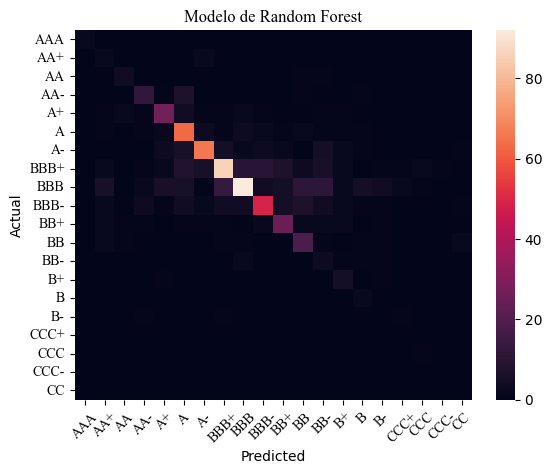

In [59]:
# plot the  Confusion Matrix for the companies in the main world index
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm,  fmt="d")
# usa All_rating_order_group como ticks en el eje x e y
ticks = np.arange(len(ratings_))+0.5
plt.xticks(ticks=ticks, labels=ratings_,rotation=45,fontname='Times New Roman')
plt.yticks(ticks=ticks, labels=ratings_,rotation=0,fontname='Times New Roman')
plt.title('Modelo de Random Forest',fontname='Times New Roman')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('plots/confusion_matrix_rf_new_data.png')
plt.show()